# `spaxelsleuth` examples (SAMI)
---
In this notebook, you will learn how to use `spaxelsleuth` to 
1. create a `pandas` DataFrame containing global information for all SAMI galaxies, e.g. stellar masses, redshifts and effective radii;
2. create a `pandas` DataFrame containing spaxel-by-spaxel information for all SAMI galaxies;
3. use the included plotting tools to analyse the SAMI data set as a whole;
4. create plots that you can use to analyse specific galaxies. 

In [2]:
from spaxelsleuth import load_user_config
load_user_config("/home/u5708159/.spaxelsleuthconfig.json")
from spaxelsleuth.config import settings

## Create the DataFrames
---
### Creating the "metadata" DataFrame
After you have installed `spaxelsleuth` and have downloaded the necessary files from [DataCentral](http://datacentral.org.au) (see the README), the first step is to create the "metadata" DataFrame containing basic information about each SAMI galaxy, such as redshifts, morphologies, and stellar masses.

In [ ]:
from spaxelsleuth.loaddata.sami import make_sami_metadata_df
make_sami_metadata_df()

In [3]:
from spaxelsleuth.loaddata.sami import load_sami_metadata_df
df_metadata = load_sami_metadata_df()

utils.py (line 148) _init_num_threads(): Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
utils.py (line 160) _init_num_threads(): NumExpr defaulting to 8 threads.


In [4]:
df_metadata[df_metadata["Good?"]]

,"Median SNR (B, full field)","Median SNR (R, full field)","Median SNR (B, 1R_e)","Median SNR (R, 1R_e)","Median SNR (B, 1.5R_e)","Median SNR (R, 1.5R_e)","Median SNR (B, 2R_e)","Median SNR (R, 2R_e)",A_g,Bad class #,...,D_L (Mpc),kpc per arcsec,R_e (kpc),R_e (MGE) (kpc),log(M/R_e),log(M/R_e^2),log(M/R_e) (MGE),log(M/R_e^2) (MGE),i (degrees),Morphology
6837,0.567761,0.641720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,335.766910,1.410620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Late spiral
7139,0.653472,0.901462,18.779948,29.744286,12.800612,19.612563,8.695532,15.264292,0.102,0.0,...,348.774353,1.457848,1.793153,1.343898,10.376383,10.122765,10.501634,10.373268,59.602065,S0
7206,1.216322,1.807957,10.689451,15.693637,8.258135,10.355650,6.201506,7.177996,0.123,0.0,...,434.400539,1.757386,5.852094,4.597360,9.712689,8.945377,9.817492,9.154983,49.024260,Early-spiral
7289,1.913341,3.235386,5.049144,8.099088,2.449893,3.891631,1.913341,3.235386,0.105,0.0,...,402.419056,1.647752,8.172850,4.857509,10.207626,9.295253,10.433586,9.747173,43.889066,E/S0
7715,1.544430,3.095637,6.193570,10.453460,2.695232,4.631049,1.588380,3.301206,0.073,0.0,...,359.768306,1.497399,6.408868,5.145143,10.183219,9.376437,10.278603,9.567205,40.706539,E/S0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9403801268,3.101705,5.499816,3.101705,5.499816,3.101705,5.499816,3.101705,5.499816,NaN,0.0,...,134.002807,0.611691,7.905436,3.123298,9.621742,8.723816,10.025055,9.530441,NaN,S0/Early-spiral
9403801272,3.626537,6.491017,3.626537,6.491017,3.626537,6.491017,3.626537,6.491017,NaN,0.0,...,154.170174,0.697664,8.912136,4.628993,9.339143,8.389161,9.623638,8.958151,53.977833,Early/Late spiral
9403801281,1.994274,3.061096,6.799327,9.255939,3.731391,5.085902,2.382575,3.673771,NaN,0.0,...,124.554204,0.570896,3.206362,2.202180,9.295841,8.789829,9.459001,9.116148,54.390071,S0/Early-spiral
9403801368,15.288632,23.418954,15.418042,23.676023,15.288632,23.418954,15.288632,23.418954,NaN,0.0,...,120.110546,0.551596,8.933950,5.551603,10.514388,9.563345,10.721014,9.976595,20.957974,E


In [4]:
df_metadata.loc[100162]

Median SNR (B, full field)       0.881227
Median SNR (R, full field)       1.146163
Median SNR (B, 1R_e)             16.16431
Median SNR (R, 1R_e)            18.501093
Median SNR (B, 1.5R_e)          11.761572
Median SNR (R, 1.5R_e)          12.063724
Median SNR (B, 2R_e)             7.434839
Median SNR (R, 2R_e)             8.189263
A_g                                 0.096
Bad class #                           0.0
ID                                 100162
Dec (IFU) (J2000)                0.934893
Dec (J2000)                      0.934893
e                                  0.4972
g - i colour                         0.59
Cluster member                        NaN
M_r                                -18.67
log M_*                              9.15
mu_r at 1R_e                        20.84
mu_r at 2R_e                        22.75
mu_r within 1R_e                    20.24
PA (degrees)                    47.020004
R_e (arcsec)                         2.75
r/R_200                           

Text(0, 0.5, '$\\log_{10}(M_*\\,[\\rm M_\\odot])$')

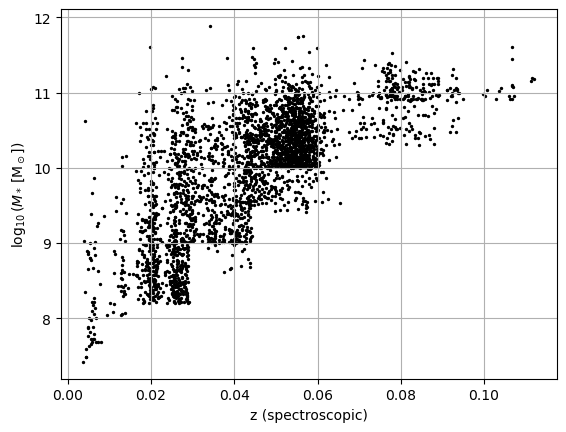

In [5]:
import matplotlib.pyplot as plt
from spaxelsleuth.plotting.plottools import get_label
fig, ax = plt.subplots()
ax.scatter(df_metadata["z (spectroscopic)"], df_metadata["log M_*"], s=2, c="k")
ax.grid()
ax.set_xlabel(get_label("z (spectroscopic)"))
ax.set_ylabel(get_label("log M_*"))

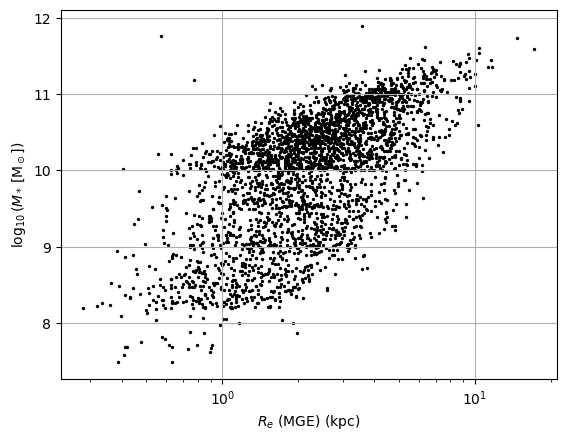

In [6]:
fig, ax = plt.subplots()
ax.scatter(df_metadata["R_e (MGE) (kpc)"], df_metadata["log M_*"], s=2, c="k")
ax.grid()
ax.set_xlabel(get_label("R_e (MGE) (kpc)"))
ax.set_ylabel(get_label("log M_*"))
ax.set_xscale("log")

### Creating the SAMI DataFrame
The next step is to create the DataFrame containing all measured quantities, such as emission line fluxes, stellar and gas kinematics, and extinction, for each individual spaxel in every SAMI galaxy. The resulting DataFrames are saved to file and can be accessed using `load_sami_df()`.

The input arguments are as follows:
* `ncomponents` determines which data set the function is run on. 
    * `ncomponents = "recom"` will use the data products produced using the multi-component Gaussian emission line fits, in which the `LZCOMP` neutral network was used to determine the optimal number of components in each spaxel.
    * `ncomponents = "1"` will use the data products produced using the single-component Gaussian emission line fits.
* `bin_type` refers to the spatial binning scheme used.
    * `bin_type = "default"` will use the data products produced using the unbinned data. 
    * `bin_type = "adaptive"` will use the data products produced using the Voronoi-binned data. 
    * `bin_type = "sectors"` will use the data products produced using the sector-binned data. 
* `eline_SNR_min` gives the minimum S/N for which a fitted emission line component will be accepted. All quantities associated with emission line components that fall below this S/N threshold (e.g. kinematics, fluxes, etc.) will be set to `np.nan`.
* `correct_extinction` controls whether extinction correction is appled to the emission line fluxes or not.
* * `metallicity_diagnostics` controls which strong-line metallicity diagnostics are evaluated.

Note that running `make_sami_df()` for all ~3,000 SAMI galaxies takes some time - for a quick demo, set `DEBUG` here to `True`; this will create the DataFrame for a subset of 10 galaxies and is much quicker.

In [7]:
DEBUG = True

In [1]:
from spaxelsleuth.loaddata.sami import make_sami_df

In [ ]:
make_sami_df(ncomponents="recom", bin_type="default", eline_SNR_min=5, correct_extinction=True, debug=DEBUG)

### Load the SAMI DataFrame we just created
Note that if `DEBUG == False`, loading the sample takes about 20 seconds - patience is a virtue!

In [8]:
from spaxelsleuth.loaddata.sami import load_sami_df
df = load_sami_df(ncomponents="recom",
                  bin_type="default",
                  eline_SNR_min=5,
                  correct_extinction=True,
                  debug=DEBUG)


sami.py (line 1474) load_sami_df(): Loading DataFrame from file /data/misfit/u5708159/SAMI/sami_default_recom-comp_extcorr_minSNR=5_DEBUG.hd5 [last modified 2023-08-24 16:33:16.650140]...


sami.py (line 1502) load_sami_df(): Finished!


In addition to the measured quantities released in DR3, the DataFrame also contains various other measurements, such as line ratios, spectral categories, equivalent widths, and the like:

In [9]:
df

,"Median SNR (B, full field)","Median SNR (R, full field)","Median SNR (B, 1R_e)","Median SNR (R, 1R_e)","Median SNR (B, 1.5R_e)","Median SNR (R, 1.5R_e)","Median SNR (B, 2R_e)","Median SNR (R, 2R_e)",A_g,Bad class #,...,ncomponents,bin_type,__use_lzifu_fits,__lzifu_ncomponents,debug,flux units,continuum units,"x, y (pixels)",Morphology,BPT (total)
0,0.567761,0.641720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,recom,default,False,3,True,E-16 erg/cm^2/s,E-16 erg/cm^2/Å/s,"(21.0, 6.0)",Late spiral,Not classified
1,0.567761,0.641720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,recom,default,False,3,True,E-16 erg/cm^2/s,E-16 erg/cm^2/Å/s,"(22.0, 6.0)",Late spiral,Not classified
2,0.567761,0.641720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,recom,default,False,3,True,E-16 erg/cm^2/s,E-16 erg/cm^2/Å/s,"(24.0, 6.0)",Late spiral,Not classified
3,0.567761,0.641720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,recom,default,False,3,True,E-16 erg/cm^2/s,E-16 erg/cm^2/Å/s,"(25.0, 6.0)",Late spiral,Not classified
4,0.567761,0.641720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,recom,default,False,3,True,E-16 erg/cm^2/s,E-16 erg/cm^2/Å/s,"(18.0, 7.0)",Late spiral,Not classified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9945,4.101596,6.936416,20.632352,30.631812,17.254502,24.699304,12.859634,18.600722,0.118,0.0,...,recom,default,False,3,True,E-16 erg/cm^2/s,E-16 erg/cm^2/Å/s,"(24.0, 41.0)",Early-spiral,Not classified
9946,4.101596,6.936416,20.632352,30.631812,17.254502,24.699304,12.859634,18.600722,0.118,0.0,...,recom,default,False,3,True,E-16 erg/cm^2/s,E-16 erg/cm^2/Å/s,"(25.0, 41.0)",Early-spiral,Not classified
9947,4.101596,6.936416,20.632352,30.631812,17.254502,24.699304,12.859634,18.600722,0.118,0.0,...,recom,default,False,3,True,E-16 erg/cm^2/s,E-16 erg/cm^2/Å/s,"(27.0, 41.0)",Early-spiral,Not classified
9948,4.101596,6.936416,20.632352,30.631812,17.254502,24.699304,12.859634,18.600722,0.118,0.0,...,recom,default,False,3,True,E-16 erg/cm^2/s,E-16 erg/cm^2/Å/s,"(28.0, 41.0)",Early-spiral,Not classified


In [10]:
for col in df.columns:
    print(col)

Median SNR (B, full field)
Median SNR (R, full field)
Median SNR (B, 1R_e)
Median SNR (R, 1R_e)
Median SNR (B, 1.5R_e)
Median SNR (R, 1.5R_e)
Median SNR (B, 2R_e)
Median SNR (R, 2R_e)
A_g
Bad class #
ID
Dec (IFU) (J2000)
Dec (J2000)
e
g - i colour
Cluster member
M_r
log M_*
mu_r at 1R_e
mu_r at 2R_e
mu_r within 1R_e
PA (degrees)
R_e (arcsec)
r/R_200
RA (IFU) (J2000)
RA (J2000)
v/sigma_cluster
z (spectroscopic)
z (flow-corrected)
Morphology (numeric)
Good?
R_e (MGE) (arcsec)
m_AB (MGE)
PA (MGE) (degrees)
e at 1R_e (MGE)
e, LW (MGE)
z
D_A (Mpc)
D_L (Mpc)
kpc per arcsec
R_e (kpc)
R_e (MGE) (kpc)
log(M/R_e)
log(M/R_e^2)
log(M/R_e) (MGE)
log(M/R_e^2) (MGE)
i (degrees)
sigma_*
sigma_* error
v_*
v_* error
HALPHA extinction correction (total)
HALPHA extinction correction error (total)
SFR surface density (total)
SFR surface density error (total)
SFR surface density (component 1)
SFR surface density error (component 1)
SFR surface density (component 2)
SFR surface density error (component 2)
SF

If we like, we can limit our DataFrame to spaxels in which *all* Gaussian emission line components meet our S/N and DQ requirements:

In [10]:
cond_bad_components = df["Missing components flag"]
df = df[~cond_bad_components]

Let's have a look at some statistics:

In [11]:
# Calculate the fraction of spaxels with different numbers of emission line components
n_spaxels_tot = df.shape[0]
for nn in range(4):
    cond = df["Number of components (original)"] == nn
    n_spaxels = df[cond].shape[0]
    print(f"There are {n_spaxels} spaxels ({n_spaxels / n_spaxels_tot * 100:.2f}%) with {nn} components as determined by LZCOMP")

There are 2118 spaxels (46.25%) with 0 components as determined by LZCOMP
There are 2022 spaxels (44.16%) with 1 components as determined by LZCOMP
There are 344 spaxels (7.51%) with 2 components as determined by LZCOMP
There are 95 spaxels (2.07%) with 3 components as determined by LZCOMP


In [12]:
# Calculate the number of spaxels with different spectral classifications 
n_spaxels_tot = df.shape[0]
spec_cats = df["BPT (total)"].unique()  # List of spectral categories in the data set
for spec_cat in spec_cats:
    cond = df["BPT (total)"] == spec_cat
    n_spaxels = df[cond].shape[0]
    print(f"There are {n_spaxels} spaxels ({n_spaxels / n_spaxels_tot * 100:.2f}%) classified as {spec_cat}")

There are 3467 spaxels (75.72%) classified as Not classified
There are 853 spaxels (18.63%) classified as SF
There are 10 spaxels (0.22%) classified as Ambiguous
There are 41 spaxels (0.90%) classified as LINER
There are 208 spaxels (4.54%) classified as Composite


Text(0, 0.5, '$N$ (normalised)')

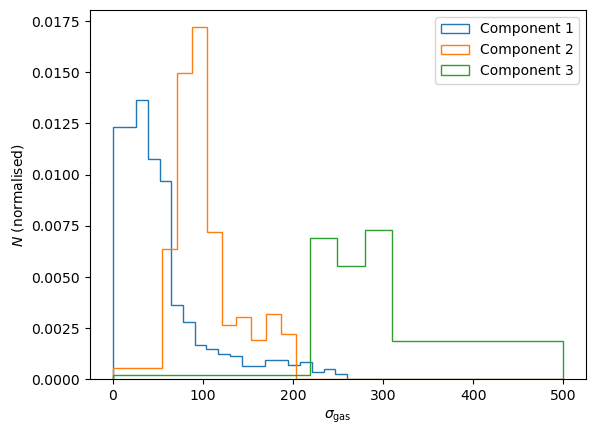

In [13]:
# Histograms showing the distribution in velocity dispersion
import matplotlib.pyplot as plt
from astropy.visualization import hist
fig, ax = plt.subplots(nrows=1, ncols=1)
for nn in range(1, 4):
    hist(df[f"sigma_gas (component {nn})"].values, bins="scott", ax=ax, range=(0, 500), density=True, histtype="step", label=f"Component {nn}")
ax.legend()
ax.set_xlabel(r"$\sigma_{\rm gas}$")
ax.set_ylabel(r"$N$ (normalised)")

You can also select a subset of the full data sample as follows:

/home/u5708159/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/u5708159/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/u5708159/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

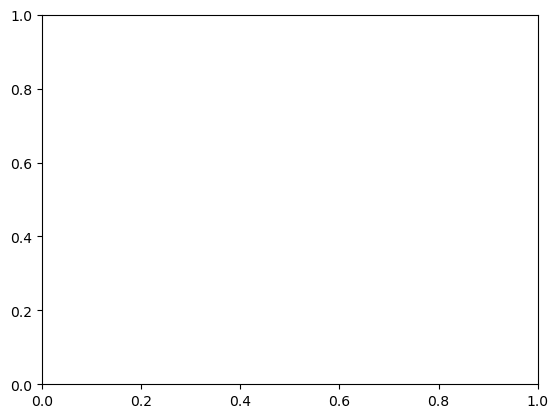

In [15]:
df_agn = df[df["BPT (total)"] == "Seyfert"]
fig, ax = plt.subplots(nrows=1, ncols=1)
for nn in range(1, 4):
    hist(df_agn[f"sigma_gas (component {nn})"].values, bins="scott", ax=ax, range=(0, 500), density=True, histtype="step", label=f"Component {nn}")
ax.legend()
ax.set_xlabel(r"$\sigma_{\rm gas}$")
ax.set_ylabel(r"$N$ (normalised)")
ax.set_title("Seyfert-like spaxels only")

## Using `spaxelsleuth.plotting` to plot the whole SAMI sample 
--- 
In the below cells, we will demonstrate how to use various functions in `spaxelsleuth.plotting` to make different kinds of plots useful for analysing the entire SAMI data set.

In [14]:
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'

In [16]:
from spaxelsleuth.plotting.plottools import plot_empty_BPT_diagram, plot_BPT_lines
from spaxelsleuth.plotting.plotgalaxies import plot2dhistcontours, plot2dscatter

logger.py (line 181) _showwarning(): /home/u5708159/python/Modules/spaxelsleuth/spaxelsleuth/plotting/plotgalaxies.py:524: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if col_z is not "count" and df[col_z].dtype == "O":



#### Plot the distribution of spaxels in the WHAN diagram
The WHAN diagram, developed by Cid Fernandes et al. (2010, 2011), plots the H$\alpha$ equivalent width (EW) against the [NII]6583Å/H$\alpha$ line ratio, and can be used to distinguish between emission by star formation, AGN and hot, low-mass evolved stars.

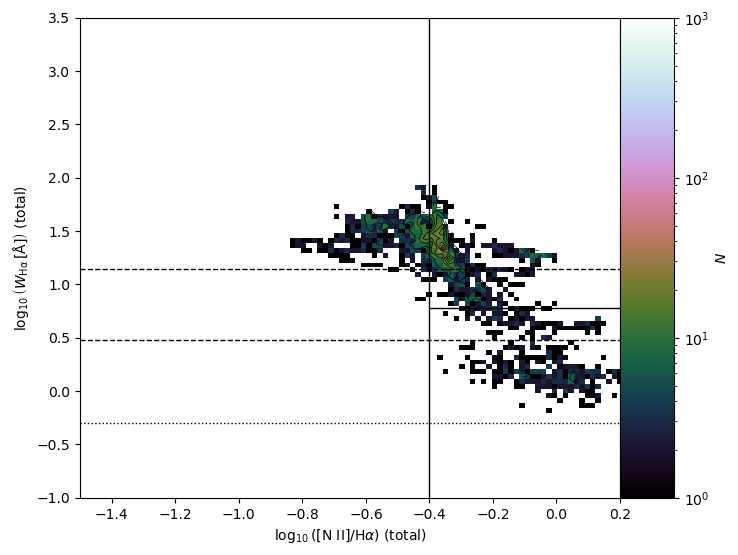

In [17]:
# Plot a 2D histogram showing the distribution of SAMI spaxels in the WHAN diagram
_ = plot2dhistcontours(df=df,
              col_x=f"log N2 (total)",
              col_y=f"log HALPHA EW (total)",
              col_z="count", log_z=True,
              plot_colorbar=True)

plotgalaxies.py (line 528) plot2dhistcontours(): 


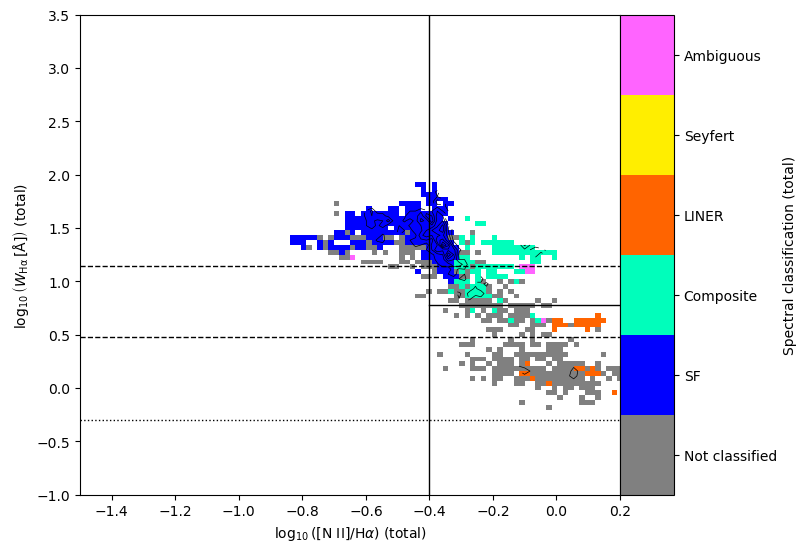

In [18]:
# Repeat the above, but colour by the median BPT classification
_ = plot2dhistcontours(df=df,
              col_x=f"log N2 (total)",
              col_y=f"log HALPHA EW (total)",
              col_z="BPT (total)", 
              plot_colorbar=True)

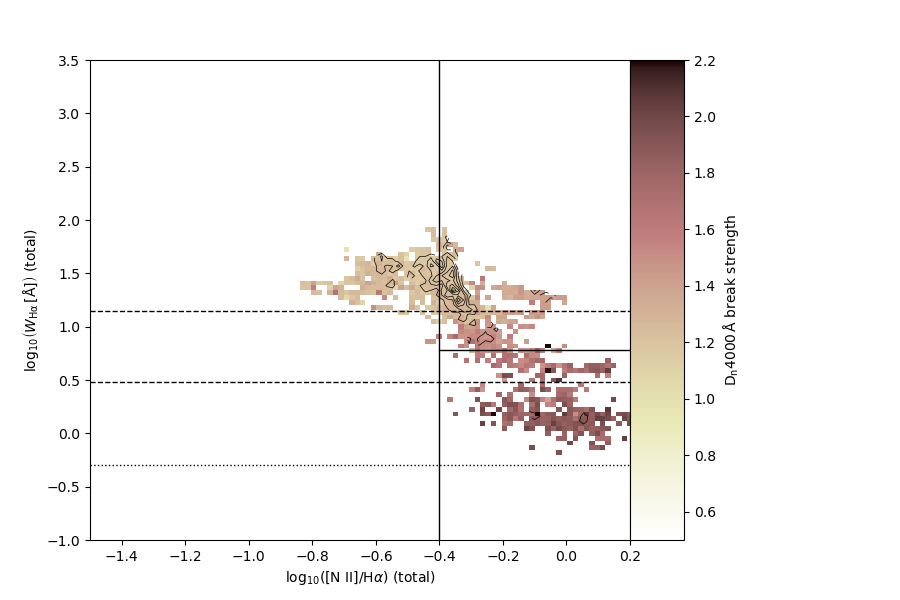

In [20]:
# Repeat the above, but colour by the D4000Å break strength
_ = plot2dhistcontours(df=df,
              col_x=f"log N2 (total)",
              col_y=f"log HALPHA EW (total)",
              col_z="D4000", 
              plot_colorbar=True)

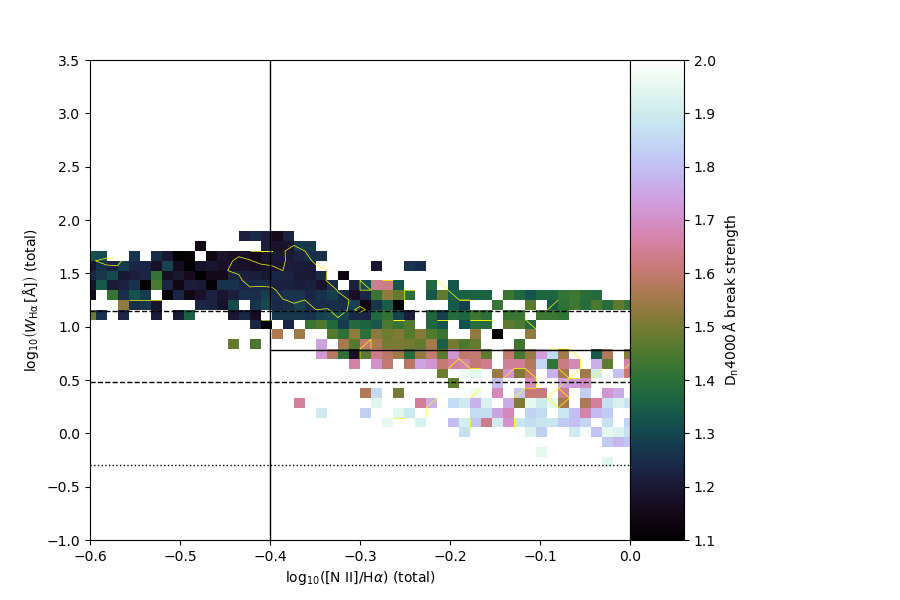

In [21]:
# If we like, we can use a different colourmap using the "cmap" keyword.
# The contour colours can also be changed using the "colors" keyword, and the levels can be changed using "levels".
# The axis limits can also be changed using the "xmin", "xmax", "ymin", "ymax" and "vmin", "vmax" keyword.
# We can also change the number of histogram bins using the "nbins" keyword.
import numpy as np
_ = plot2dhistcontours(df=df,
              col_x=f"log N2 (total)", xmin=-0.6, xmax=0.0,
              col_y=f"log HALPHA EW (total)", 
              col_z="D4000", vmin=1.1, vmax=2.0,
              nbins=50, 
              cmap="cubehelix", colors="yellow", levels=np.logspace(0, 4, 5),
              plot_colorbar=True)

#### Plot optical diagnostic ("BPT") diagrams for the full sample, showing the distribution of spaxels in all SAMI galaxies

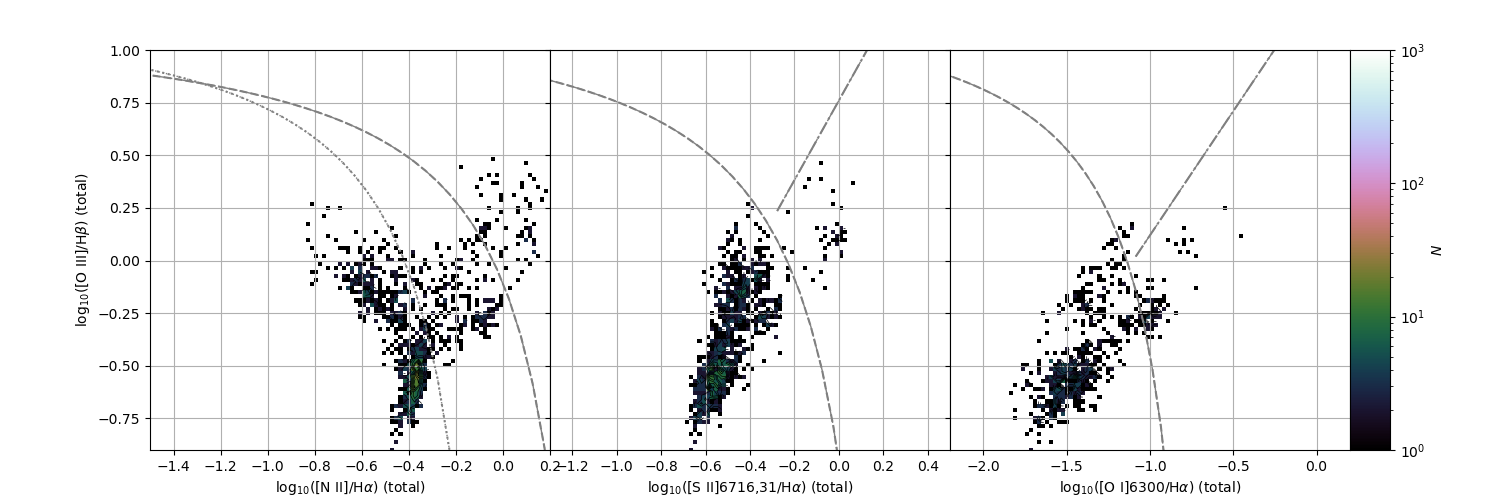

In [22]:
# Plot an empty BPT diagram
fig, axs_bpt = plot_empty_BPT_diagram(nrows=1)

# Plot 2D histograms showing the distribution of the entire sample
for cc, col_x in enumerate(["log N2", "log S2", "log O1"]):
    # Add BPT demarcation lines
    plot_BPT_lines(ax=axs_bpt[cc], col_x=col_x)    

    # Plot histograms showing distribution for whole sample
    _ = plot2dhistcontours(df=df,
                  col_x=f"{col_x} (total)",
                  col_y=f"log O3 (total)",
                  col_z="count", log_z=True,
                  ax=axs_bpt[cc],
                  cax=None,
                  plot_colorbar=True if cc==2 else False)

    if cc > 0:
        axs_bpt[cc].set_ylabel("")
    axs_bpt[cc].grid()

#### Repeat the above, but colour the histograms by $\sigma_{\rm gas}$ for the narrowest component (component 1)

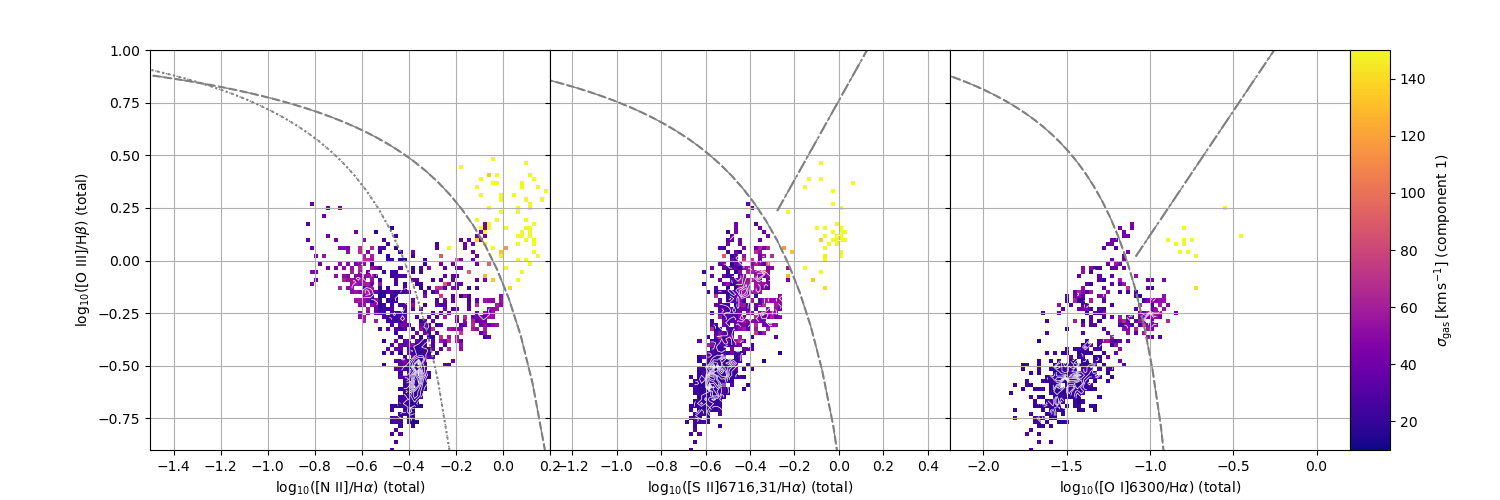

In [24]:
# Plot an empty BPT diagram
fig, axs_bpt = plot_empty_BPT_diagram(nrows=1)

# Plot 2D histograms showing the distribution of the entire sample
for cc, col_x in enumerate(["log N2", "log S2", "log O1"]):
    # Add BPT demarcation lines
    plot_BPT_lines(ax=axs_bpt[cc], col_x=col_x)    

    # Plot histograms showing distribution for whole sample
    _ = plot2dhistcontours(df=df,
                  col_x=f"{col_x} (total)",
                  col_y=f"log O3 (total)",
                  col_z="sigma_gas (component 1)", 
                  vmax=150,  # Tweak the z-axis scaling to bring out details 
                  ax=axs_bpt[cc],
                  cax=None, colors="white",
                  plot_colorbar=True if cc==2 else False)
    
    if cc > 0:
        axs_bpt[cc].set_ylabel("")
    axs_bpt[cc].grid()

## Using `spaxelsleuth.plotting` to plot individual galaxies
--- 
In the below cells, we will demonstrate how create plots based on individual SAMI galaxies using functions in `spaxelsleuth.plotting`.


In [19]:
# Pick a galaxy, based on its GAMA ID. 
gal = 572402  # This one is my favourite.

#### Plot the SDSS image 
----
`plot_sdss_image()` retrieves an RGB SDSS image using the DR16 Image Cutout service and plots it, overlaid with the SAMI field-of-view plus a scale bar to show the physical scale at the galaxy's redshift. If the galaxy lies outside the SDSS footprint (which is the case for some cluster targets) then no image is displayed. 

Text(0.5, 1.0, '572402')

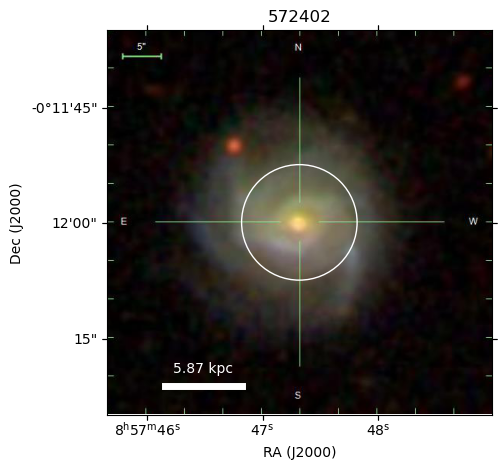

In [20]:
from spaxelsleuth.plotting.sdssimg import plot_sdss_image
ax = plot_sdss_image(df=df, gal=gal)
ax.set_title(f"{gal}")


#### Plot 2D maps showing various quantities in this galaxy
Given a DataFrame corresponding to a single galaxy, `plot2dmap()` reconstructs a 2D image of a specified column (e.g., velocity dispersion) from the rows and plots it. 

logger.py (line 181) _showwarning(): /home/u5708159/python/Modules/spaxelsleuth/spaxelsleuth/plotting/plot2dmap.py:193: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if bin_type is not "default":

logger.py (line 181) _showwarning(): /home/u5708159/python/Modules/spaxelsleuth/spaxelsleuth/plotting/plot2dmap.py:196: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if bin_type is not "default":

plot2dmap.py (line 152) plot2dmap(): 


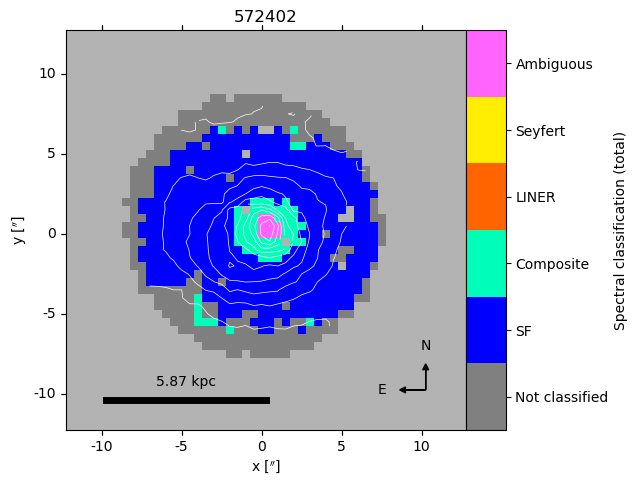

In [21]:
from spaxelsleuth.plotting.plot2dmap import plot2dmap
fig, ax = plot2dmap(df=df, gal=gal, col_z="BPT (total)")


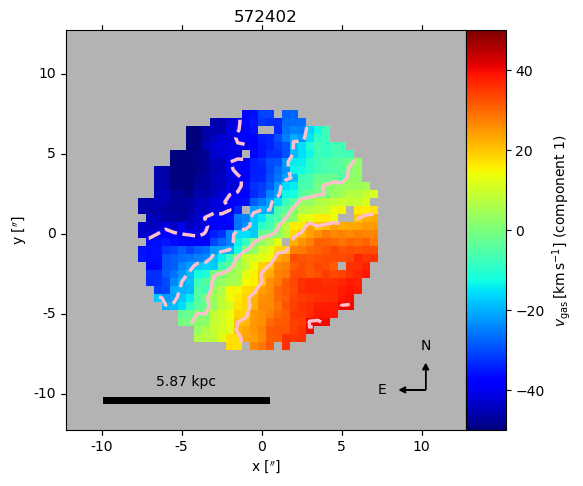

In [22]:
# Playing with input arguments 
# As in plot2dhistcontours, the maximum colour scaling can be set using "vmin" and "vmax" and the colourmap can be changed using "cmap". 
# The quantity that is used to plot contours can be set to any column in the DataFrame using "col_z_contours" and the colours and linewidths can be configured using "colours" and "linewidths".
_ = plot2dmap(df=df, gal=gal, col_z="v_gas (component 1)",
              cmap="jet", vmin=-50, vmax=+50,
              col_z_contours="v_gas (component 1)", levels=[-40, -20, 0, 20, 40], colors="pink", linewidths=2.5)


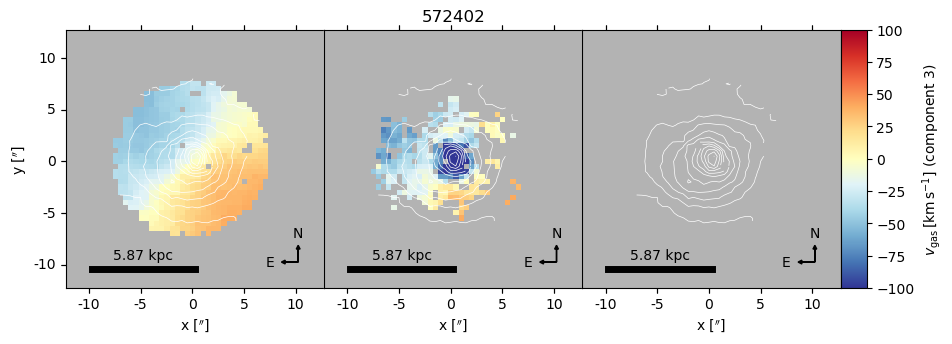

In [23]:
# Slightly more advanced example: plot the gas velocity for each individual component.
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
fig.subplots_adjust(wspace=0)

for nn in range(3):
    # Pass the axis to plot_2dmap()
    fig, ax = plot2dmap(df=df, gal=gal, col_z=f"v_gas (component {nn + 1})",
                        vmin=-100, vmax=+100,
                        ax=axs[nn], plot_colorbar=True if nn == 2 else False, show_title=True if nn == 1 else False)

# In plot2dmap, the existing axis has to be destroyed and replaced with an identical axis with the correct WCS. Therefore, we need to update our list of axes.
axs_new = fig.get_axes()[:-1]

# Turn off the y-axis ticks on axes 2 and 3
for ax in axs_new[1:]:
    lon = ax.coords[0]
    lat = ax.coords[1]
    lat.set_ticks_visible(False)
    lat.set_ticklabel_visible(False)


#### Scatter plots 
Create a BPT diagram with 2D histograms and contours showing the distribution in the full sample, with the data points from this galaxy overlaid on top using a scatter plot.

[Text(0, 0.5, ''), Text(0, 0.5, '')]

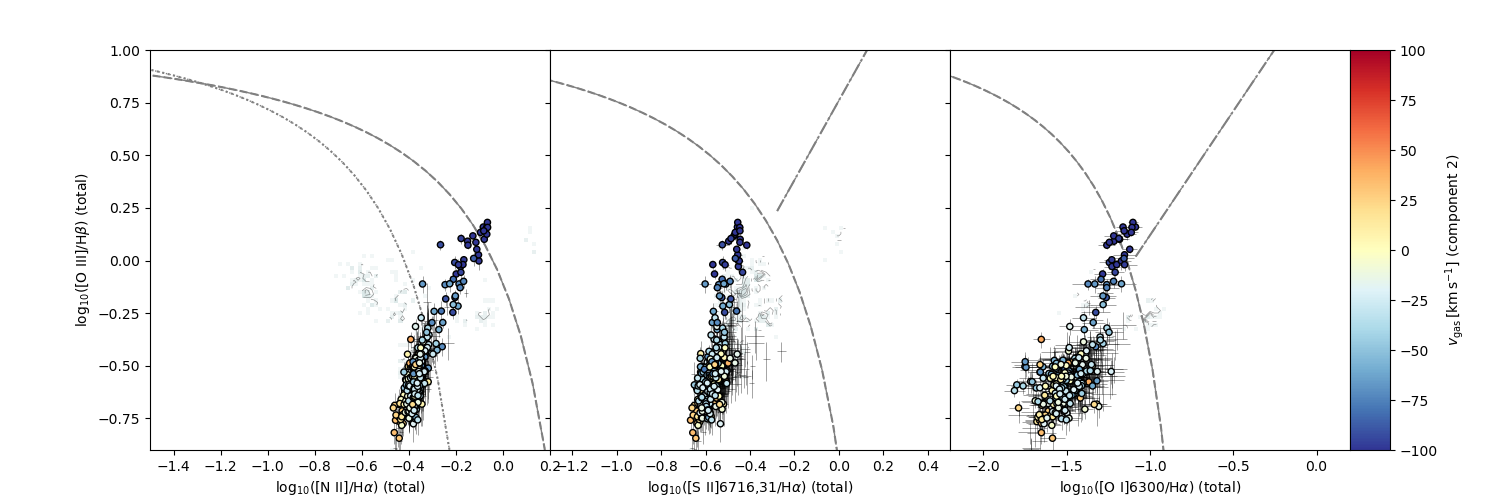

In [28]:
# Plot an empty BPT diagram
fig, axs_bpt = plot_empty_BPT_diagram(nrows=1)

# Plot 2D histograms showing the distribution of the entire sample
for cc, col_x in enumerate(["log N2", "log S2", "log O1"]):
    # Add BPT demarcation lines
    plot_BPT_lines(ax=axs_bpt[cc], col_x=col_x)    

    # Plot histograms showing distribution for whole sample
    _ = plot2dhistcontours(df=df,
                  col_x=f"{col_x} (total)",
                  col_y=f"log O3 (total)",
                  col_z="count", log_z=True,
                  cmap="bone_r", alpha=0.4,
                  ax=axs_bpt[cc],
                  plot_colorbar=False)
    
    # Scatter plot for this galaxy
    _ = plot2dscatter(df=df, gal=gal, 
                      col_x=f"{col_x} (total)",
                      col_y=f"log O3 (total)",
                      col_z=f"v_gas (component 2)",
                      ax=axs_bpt[cc],
                      vmin=-100, vmax=+100,
                      plot_colorbar=True if cc==2 else False)
    
# Turn of y-axis labels 
[ax.set_ylabel("") for ax in axs_bpt[1:]]